In [77]:
# Imports
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

In [78]:
#gpu memory growth fix
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [79]:
# Loading data about Gazprom stock prices for the last 13 years
data = pd.read_csv('E:/Python/data/gazprom_prices.csv', sep=';', decimal=',')
data

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,08.02.2021,223.04,226.75,227.77,223.00,67207330
1,05.02.2021,220.68,221.86,222.21,219.00,42219420
2,04.02.2021,218.70,218.08,221.40,216.88,47943720
3,03.02.2021,215.42,217.12,218.42,213.79,46028500
4,02.02.2021,215.60,216.70,219.74,213.25,78073300
...,...,...,...,...,...,...
3266,15.01.2008,364.00,360.24,365.20,358.39,57391670
3267,14.01.2008,355.11,363.70,365.64,353.77,61086074
3268,11.01.2008,352.28,355.91,357.43,349.81,52499924
3269,10.01.2008,353.54,352.40,355.42,352.01,32180831


In [80]:
# We need only Close prices
stocks = data.iloc[:, 2].values
stocks

array([226.75, 221.86, 218.08, ..., 355.91, 352.4 , 352.69])

In [81]:
# Min Max Data Scaling
stocks = stocks.reshape(-1, 1)
from sklearn.preprocessing import MinMaxScaler
mmsc = MinMaxScaler(feature_range = (0, 1))
stocks = mmsc.fit_transform(stocks)
stocks

array([[0.49910969],
       [0.48169516],
       [0.46823362],
       ...,
       [0.9590812 ],
       [0.9465812 ],
       [0.94761396]])

In [82]:
# Creating a data structure with 10 time-steps and 1 output
# Training data
time_steps = 30
test_size = 300
X_train = []
y_train = []
for i in range(time_steps, 2500):
    X_train.append(stocks[i-time_steps:i])
    y_train.append(stocks[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# Validation data
X_val = []
y_val = []
for i in range(2501, stocks.shape[0]-test_size):
    X_val.append(stocks[i-time_steps:i])
    y_val.append(stocks[i])
X_val, y_val = np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
# Test data: last 100 days
X_test = []
y_test = []
for i in range(stocks.shape[0]-test_size, stocks.shape[0]):
    X_test.append(stocks[i-time_steps:i])
    y_test.append(stocks[i])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [83]:
# Making LSTM-model itself
# Settings
BATCH_SIZE = 16
TOL = 0.0001
N_ITER_NO_CHANGE = 10
VERBOSE = 1
MAX_EPOCHS = 50

# model layers
model = Sequential()
# model.add(layers.LSTM(512, return_sequences = True, input_shape=(X_train.shape[1], 1)))
# model.add(layers.Dropout(0.5))
# model.add(layers.LSTM(512))
# model.add(layers.Dropout(0.5))
model.add(layers.LSTM(512, input_shape=(X_train.shape[1], 1)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
# model compiler
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.002, \
    beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=TOL, verbose=VERBOSE, patience=N_ITER_NO_CHANGE)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=VERBOSE, save_best_only=True)

# reducting learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [84]:
# fit model and save the best
history = model.fit(x=X_train, y=y_train, 
#                     steps_per_epoch=steps_per_epoch, epochs=MAX_EPOCHS, 
                    validation_data=(X_val, y_val), 
                    batch_size=BATCH_SIZE, epochs=MAX_EPOCHS,
                    callbacks=[tensorboard, es, mc, rlrop])
saved_model = load_model('best_model.h5')

Epoch 1/50
155/155 [==============================] - ETA: 0s - loss: 0.0016- ETA: 1s - 
Epoch 00001: val_loss improved from inf to 0.00043, saving model to best_model.h5
155/155 [==============================] - 16s 106ms/step - loss: 0.0016 - val_loss: 4.2698e-04
Epoch 2/50
155/155 [==============================] - ETA: 0s - loss: 4.2534e-04- ETA: 0s - loss: 4.2721e
Epoch 00002: val_loss did not improve from 0.00043
155/155 [==============================] - 11s 73ms/step - loss: 4.2534e-04 - val_loss: 6.6219e-04
Epoch 3/50
155/155 [==============================] - ETA: 0s - loss: 3.5483e-04
Epoch 00003: val_loss did not improve from 0.00043
155/155 [==============================] - 11s 71ms/step - loss: 3.5483e-04 - val_loss: 6.8919e-04
Epoch 4/50
155/155 [==============================] - ETA: 0s - loss: 3.4272e-04
Epoch 00004: val_loss improved from 0.00043 to 0.00039, saving model to best_model.h5
155/155 [==============================] - 11s 73ms/step - loss: 3.4272e-04 - v

In [85]:
# Predicting and getting back to old scale
predicted_stock_price = saved_model.predict(X_test)
predicted_stock_price = mmsc.inverse_transform(predicted_stock_price)
# predicted_stock_price

In [86]:
# get test data to old scale
y_test1 = mmsc.inverse_transform(y_test)
# y_test1

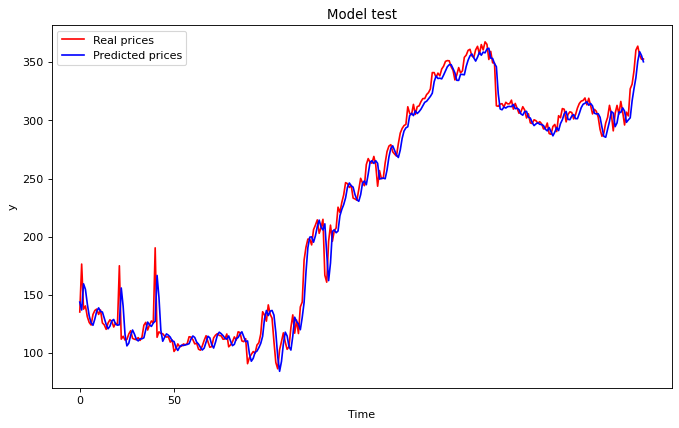

In [92]:
# Visualising the results
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_test1, color = 'red', label = 'Real prices')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted prices')
plt.xticks(np.arange(0, 100, 50))
plt.title('Model test')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()
plt.show()

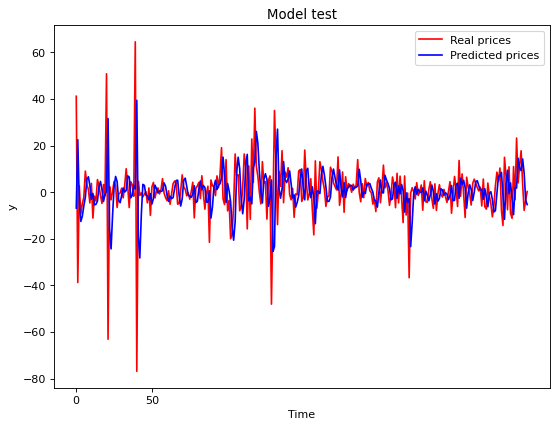

In [88]:
# Now see how well the model predicts if price falls next day or not
predicted_stock_diff = [predicted_stock_price[i][0]-predicted_stock_price[i-1][0] 
                        for i in range(1,predicted_stock_price.shape[0])]
predicted_stock_diff
real_stock_diff = [y_test1[i][0]-y_test1[i-1][0] 
                        for i in range(1,y_test1.shape[0])]
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(real_stock_diff, color = 'red', label = 'Real prices')
plt.plot(predicted_stock_diff, color = 'blue', label = 'Predicted prices')
plt.xticks(np.arange(0, 100, 50))
plt.title('Model test')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()
plt.show()

In [89]:
# let's see how good the model predicts if price will fail
prediction_accuracy = [1 if x[0]*x[1]>0 else -1 for x in zip(predicted_stock_diff, real_stock_diff)]
np.sum(prediction_accuracy)

-35

Unfortunately, the model is not good at it

In [91]:
# What if a trader reacts only if predicted difference is more than 10 units
prediction_accuracy1 = [1 if (x[0]*x[1]>0 and abs(x[0])>10) 
                        else -1 if abs(x[0])>10 else 0 
                        for x in zip(predicted_stock_diff, real_stock_diff)]
np.sum(prediction_accuracy1)

2

It does better job if we make actions only when model predicts difference more than 10 units